In [1]:
!nvidia-smi
!pip install gdown

Mon May 29 18:28:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        Off  | 00000000:00:05.0 Off |                  Off |
| 26%   25C    P8     6W / 180W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Pretrain

In [10]:
!gdown --id "19WHubFXw4PyN36hZi8OPwuobPmThDvT9&confirm=t"

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19WHubFXw4PyN36hZi8OPwuobPmThDvT9&confirm=t
To: /notebooks/norm_data_100_128.pt
100%|██████████████████████████████████████| 9.20M/9.20M [00:00<00:00, 37.5MB/s]


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from typing import List, Tuple


class Eops():
  # Following https://betterprogramming.pub/how-to-make-your-pytorch-code-run-faster-93079f3c1f7b
  def zero_grad(self):
    for parameter in self.parameters():
      parameter.grad = None

  def _init_weights(self, module: nn.Module):
    classname = module.__class__.__name__
    if classname.find("Linear") != -1:
      nn.init.xavier_uniform_(module.weight)
      if module.bias is not None:
        nn.init.zeros_(module.bias)
    elif classname.find("Conv") != -1:
      nn.init.xavier_uniform_(module.weight)

  def spectral_norm(self, module: nn.Module):
    classname = module.__class__.__name__
    if classname.find("Linear") != -1 or classname.find("Conv") != -1:
      module = torch.nn.utils.parametrizations.spectral_norm(module=module)

  def num_params(self):
    return f"{self.__class__.__name__}: {sum(p.numel() for p in self.parameters())/1e6} M parameters"
  
  def load_pretrained(self, filepath, device="cpu"):
    print(f"Loading weights for {self.__class__.__name__} from {filepath}")
    print(self.load_state_dict(torch.load(filepath, map_location=torch.device(device))))


class TripletLoss(nn.Module):
  def __init__(self, margin: float = 1.5):
    super(TripletLoss, self).__init__()
    self.register_buffer("margin", torch.tensor(margin))

  def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor = None) -> Tuple[torch.Tensor]:
    """
    Goal: Anchor / Positive -> minimize distance, Anchor / Negative -> maximize distance 
    Implementation available in PyTorch (does not include squaring the distances): nn.TripletMarginLoss(1.5)(anchor, positive, negative).
    """
    loss_dict = { "loss": None }
    euclidean_distance_positive = torch.mean(F.pairwise_distance(anchor, positive, keepdim=True), dim=1)
    loss_dict["ap_distance"] = euclidean_distance_positive
    if negative is not None:
      euclidean_distance_negative = torch.mean(F.pairwise_distance(anchor, negative, keepdim=True), dim=1)
      loss = torch.mean(torch.relu(torch.pow(euclidean_distance_positive, 2) - torch.pow(euclidean_distance_negative, 2) + self.margin))
      loss_dict["loss"] = loss
      loss_dict["an_distance"] = euclidean_distance_negative
      # difference should be > 0 (Anchor-Negative distance should be greater than Anchor-Positive distance)
      loss_dict["an_ap_diff"] = loss_dict["an_distance"] - loss_dict["ap_distance"]

    return loss_dict

In [12]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from time import time 
from tqdm import tqdm

#================ Variables ================#
torch.manual_seed(20801)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 128 
leaky_relu_slope = 0.05

block_size = 16  # -> window size for the dataset (length of the context)
latent_dim = 500 # -> size of the latent space
embedding_dim = 144 # -> embedding dimension for the condition 
sa_num_heads = 6  # -> head size in Self-Attention blocks
ca_num_heads = 6 # -> number of heads in Cross-Attention block - each head with a size of embedding_dim // num_heads = 192 / 6 = 32
attn_dropout = 0.2 # -> dropout for Attention blocks
ffn_dropout = 0.2 # -> dropout for feed-forward networks
fc_cond_inner = 128 # -> size of inner layer of condition embedding (TODO: 256)
# inner_mapping = Mapper().inner_mapping   # -> used to convert the real ASCII key symbols to range [0; 100] 
vocab_size = 101 # -> to be used in ks_embedding_table, equals to 100
generator_output_dim = 2 # -> generate 4 values for each symbol (64 in total)
lstm_hidden_size = 192  # the value divisible by sa_num heads. self-attention block: 192 / 6 = 32 channels per head


class Generator(nn.Module, Eops):
  def __init__(self):
    super(Generator, self).__init__()
    self.label_conditioned_generator = nn.Sequential(
      nn.Embedding(vocab_size, embedding_dim),
      nn.Linear(embedding_dim, 512, bias=False)
    )

    self.latent = nn.Sequential(
      nn.Linear(latent_dim, 8 * 16 * 64, bias=False),
      nn.LeakyReLU(leaky_relu_slope, inplace=True)
    )

    self.lstm1 = nn.LSTM(input_size=1024, hidden_size=128, num_layers=2, bias=False, batch_first=True, dropout=0.2)
    self.fc = nn.Linear(in_features=128, out_features=512, bias=False)

    self.model = nn.Sequential(
      nn.LeakyReLU(leaky_relu_slope, inplace=True),
      nn.Linear(in_features=512, out_features=1024, bias=False),
      nn.LayerNorm(1024),
      nn.LeakyReLU(leaky_relu_slope, inplace=True),
      nn.Linear(in_features=1024, out_features=256, bias=False),
      nn.LayerNorm(256),
      nn.LeakyReLU(leaky_relu_slope, inplace=True),
      nn.Dropout(ffn_dropout),
      nn.Linear(in_features=256, out_features=128, bias=False),
      nn.LayerNorm(128),
      nn.LeakyReLU(leaky_relu_slope, inplace=True),
      nn.Linear(in_features=128, out_features=generator_output_dim, bias=False),
      nn.Sigmoid()
    )

    self.apply(self._init_weights)

  def forward(self, latent_space, condition):
    condition_out = self.label_conditioned_generator(condition)
    latent_out = self.latent(latent_space)
    condition_out = condition_out.view(-1, 16, 4 * 128)
    latent_out = latent_out.view(-1, 16, 4 * 128)
    concat = torch.cat((latent_out, condition_out), dim=2)

    x, _ = self.lstm1(concat)
    x = self.fc(x)
    x = F.dropout(x, 0.5)
    x = self.model(x)


    return x


class Discriminator(nn.Module, Eops):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.label_conditioned_discriminator = nn.Sequential(
      nn.Embedding(vocab_size, embedding_dim),
      nn.Linear(embedding_dim, 32, bias=False)
    )

    self.embed_keystroke = nn.Sequential(
      nn.Linear(in_features=generator_output_dim, out_features=512),
      nn.LeakyReLU(leaky_relu_slope, inplace=True)
    )

    self.lstm1 = nn.LSTM(input_size=544, hidden_size=128, num_layers=2, bias=False, batch_first=True, dropout=0.2)
    self.fc = nn.Linear(in_features=128, out_features=1024, bias=False)

    self.model = nn.Sequential(
      nn.LeakyReLU(leaky_relu_slope, inplace=True),
      nn.Linear(1024, 512),
      nn.LeakyReLU(leaky_relu_slope, inplace=True),
      nn.Dropout(ffn_dropout * 2),
      nn.Linear(512, 256),
      nn.LeakyReLU(leaky_relu_slope, inplace=True),
      nn.Linear(256, 1),
    )

    self.head = nn.Linear(16, 1)
    self.sigmoid = nn.Sigmoid()
    self.apply(self._init_weights)

  def forward(self, keystroke_times, condition_symbols):
    condition_out = self.label_conditioned_discriminator(condition_symbols)
    keystroke_times = self.embed_keystroke(keystroke_times)
    x = torch.cat((keystroke_times, condition_out), dim=2)
    x, _ = self.lstm1(x)
    x = self.fc(x)
    x = F.dropout(x, 0.5)
    x = self.model(x)
    x = x.view(batch_size, -1)
    x = self.head(x)

    return self.sigmoid(x)

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm


#================ Variables ================#
num_epochs = 500    # -> number of time the model will see whole dataset
epoch_log = 1 # -> prints per epoch 
evaluation_interval = 25 # -> evaluate model every 'revaluation_interval' epochs
evaluation_steps = 50  # -> number of iterations for evaluation process (how many batches will be used)

generator_lr = 3e-4  # -> generator learning rate
discriminator_lr = 4e-4 # -> discriminator learning rate
adam_beta1 = 0.5 # -> beta1 for AdamW optimizer
adam_beta2 = 0.999 # -> beta2 (momentum) value for AdamW optimizer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


@torch.no_grad()
def evaluate_model(generator, discriminator, dataloader):
  generator.eval()
  discriminator.eval()
  real_accuracy, fake_accuracy = 0, 0
  reconstruction_loss = 0
  kl_div = 0

  for i, (ks_symbols, ks_times) in enumerate(dataloader):
    ks_times, ks_symbols = ks_times.to(device), ks_symbols.to(device)
    latent_space = torch.randn(ks_symbols.shape[0], latent_dim, device=device)
    generated_out = generator(latent_space, ks_symbols)
    reconstruction_loss += F.mse_loss(input=generated_out, target=ks_times).item()
    kl_div += distribution_similarity(generated_out, ks_times)

    labels = torch.ones(ks_symbols.shape[0], 1, device=device)
    disc_real_output = discriminator(ks_times, ks_symbols)
    real_accuracy += (torch.round(disc_real_output) == labels).float().mean().item()
    
    labels.fill_(0.)

    disc_fake_output = discriminator(generated_out, ks_symbols)
    fake_accuracy += (torch.round(disc_fake_output) == labels).float().mean().item()

    if i == evaluation_steps - 1:
      break

  reconstruction_loss /= evaluation_steps
  kl_div /= evaluation_steps
  real_accuracy /= evaluation_steps
  fake_accuracy /= evaluation_steps

  discriminator.train()
  generator.train()

  return reconstruction_loss, kl_div, real_accuracy, fake_accuracy


def distribution_similarity(generated_dist, actual_dist):
  generated_scaled = (generated_dist - actual_dist.mean()) / actual_dist.std()  # if similar to actual -> result should be close to the normal one 
  kl_loss = torch.log(generated_scaled.std()) + (1 + torch.square(generated_scaled.mean())) / (2 * torch.square(generated_scaled.std())) - 0.5 # compare with the normal one 
  return kl_loss


def calculate_loss(input, target):
  return F.binary_cross_entropy(input, target)


def reconstruction_loss(input, target):
  return F.mse_loss(input=input, target=target).item()


def train_step(models, optims, keystrokes, keystroke_times, rl_loss_lambda):
  generator, discriminator = models
  optim_G, optim_D = optims

  # 1. Prepare data (set real / fake labels)
  keystrokes, real_keystroke_times = keystrokes.to(device), keystroke_times.to(device)
  real_label = torch.ones(keystrokes.shape[0], 1, device=device)
  fake_label = torch.zeros(keystrokes.shape[0], 1, device=device)

  # 2. Train the discriminator
  discriminator.zero_grad()
  real_loss_D = calculate_loss(discriminator(real_keystroke_times, keystrokes), real_label)
  latent_space = torch.randn(keystrokes.shape[0], latent_dim, device=device)
  generated_keystroke_times = generator(latent_space, keystrokes)
  fake_loss_D = calculate_loss(discriminator(generated_keystroke_times.detach(), keystrokes), fake_label)
  total_loss_D = (real_loss_D + fake_loss_D) / 2
  mse_loss = reconstruction_loss(generated_keystroke_times, real_keystroke_times)
  total_loss_D = total_loss_D + rl_loss_lambda * mse_loss
  total_loss_D.backward()
  optim_D.step()

  # 3. Train the generator
  generator.zero_grad()
  loss_G = calculate_loss(discriminator(generated_keystroke_times, keystrokes), real_label)
  loss_G = loss_G + rl_loss_lambda * mse_loss
  loss_G.backward()
  optim_G.step()

  return loss_G, total_loss_D, mse_loss


def train_loop(generator, discriminator, train_dataloader, validation_dataloader, device=device, rl_loss_lambda=5, verbose=10):
  loss_list_D, loss_list_G, mse_losses = [], [], []
  real_accuracies, fake_accuracies, eval_reconstruction_losses, kl_divergences = [], [], [], [] 
  generator, discriminator = generator.to(device), discriminator.to(device)
  optim_G = torch.optim.AdamW(generator.parameters(), lr=generator_lr, betas=(adam_beta1, adam_beta2))
  optim_D = torch.optim.AdamW(discriminator.parameters(), lr=discriminator_lr, betas=(adam_beta1, adam_beta2))

  for epoch in tqdm(range(1, num_epochs + 1)):
    curr_loss_G, curr_loss_D, curr_mse = 0, 0, 0
    for index, (keystroke_symbols, keystroke_times) in enumerate(train_dataloader):
      if keystroke_symbols.shape[0] < batch_size:
        continue
      loss_G, loss_D, mse_loss = train_step(models=(generator, discriminator), optims=(optim_G, optim_D), 
                                  keystrokes=keystroke_symbols, keystroke_times=keystroke_times, rl_loss_lambda=rl_loss_lambda)
      curr_loss_G += loss_G.item()
      curr_loss_D += loss_D.item()
      curr_mse += mse_loss

      # if index % (len(train_dataloader) // epoch_log) == 0:
      #   print(f"[Epoch: {epoch} / {num_epochs}][{index:4d}/{len(train_dataloader):4d}] Generator loss: {loss_G:2.5f}, discriminator loss: {loss_D:2.5f}")
    
    if epoch % evaluation_interval == 0:
      loss, kl_div, real_accuracy, fake_accuracy = evaluate_model(generator, discriminator, validation_dataloader)
      real_accuracies.append(real_accuracy)
      fake_accuracies.append(fake_accuracy)
      eval_reconstruction_losses.append(loss)
      kl_divergences.append(kl_div)
      print(f"MSE loss: {loss:2.5f}, KL div: {kl_div:2.5f}, Real accuracy: {real_accuracy:2.5f}, Fake accuracy: {fake_accuracy:2.5f}")

    curr_loss_G /= len(train_dataloader)
    curr_loss_D /= len(train_dataloader)
    curr_mse /= len(train_dataloader)
    loss_list_D.append(curr_loss_D)
    loss_list_G.append(curr_loss_G)
    mse_losses.append(curr_mse)

    if epoch % verbose == 0:
      print(f"###### [Epoch: {epoch} / {num_epochs}] Epoch MSE loss: {curr_mse:2.10f} Epoch generator loss: {curr_loss_G:2.5f}, Epoch discriminator loss: {curr_loss_D:2.5f}")

  return loss_list_G, loss_list_D, mse_losses, eval_reconstruction_losses, kl_divergences, real_accuracies, fake_accuracies


In [58]:
!ls

 MNIST		    models		     one-user-norm-32.pt
 README.md	    msc			     quick_start_pytorch_images
'UCI HAR Dataset'   norm_data_10000_128.pt   tsa_project.ipynb
 __MACOSX	    norm_data_1000_128.pt   'view?usp=sharing'
 data		    norm_data_100_128.pt    'view?usp=sharing.1'
 dataset.zip	    norm_data_5000_128.pt
 dcgan.ipynb	    norm_data_50_128.pt


In [59]:
dataloader = torch.load("norm_data_100_128.pt")
len(dataloader), len(dataloader.dataset)

(375, 47885)

In [60]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

/tmp/ipykernel_33/3592223321.py:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(module.weight)


In [61]:
torch.manual_seed(20801)

loss_list_G, loss_list_D, mse_losses, reconstruction_losses, kl_divergences, real_accuracies, fake_accuracies = train_loop(generator, 
                                                                                                                           discriminator, 
                                                                                                                           dataloader, 
                                                                                                                           dataloader)

  2%|▏         | 10/500 [02:10<1:46:16, 13.01s/it]

###### [Epoch: 10 / 500] Epoch MSE loss: 0.0016019821 Epoch generator loss: 0.69976, Epoch discriminator loss: 0.69937


  4%|▍         | 20/500 [04:21<1:45:07, 13.14s/it]

###### [Epoch: 20 / 500] Epoch MSE loss: 0.0013094615 Epoch generator loss: 0.69798, Epoch discriminator loss: 0.69787


  5%|▌         | 25/500 [05:27<1:44:57, 13.26s/it]

MSE loss: 0.00088, KL div: 1.23195, Real accuracy: 0.55703, Fake accuracy: 0.46687


  6%|▌         | 30/500 [06:32<1:42:31, 13.09s/it]

###### [Epoch: 30 / 500] Epoch MSE loss: 0.0012040880 Epoch generator loss: 0.69734, Epoch discriminator loss: 0.69735


  8%|▊         | 40/500 [08:42<1:39:50, 13.02s/it]

###### [Epoch: 40 / 500] Epoch MSE loss: 0.0012469513 Epoch generator loss: 0.69753, Epoch discriminator loss: 0.69754


 10%|█         | 50/500 [10:53<1:38:51, 13.18s/it]

MSE loss: 0.00117, KL div: 0.04514, Real accuracy: 0.84313, Fake accuracy: 0.15422
###### [Epoch: 50 / 500] Epoch MSE loss: 0.0023373631 Epoch generator loss: 0.70297, Epoch discriminator loss: 0.70299


 12%|█▏        | 60/500 [13:04<1:35:40, 13.05s/it]

###### [Epoch: 60 / 500] Epoch MSE loss: 0.0020765816 Epoch generator loss: 0.70169, Epoch discriminator loss: 0.70168


 14%|█▍        | 70/500 [15:14<1:33:31, 13.05s/it]

###### [Epoch: 70 / 500] Epoch MSE loss: 0.0062561397 Epoch generator loss: 0.72343, Epoch discriminator loss: 0.72259


 15%|█▌        | 75/500 [16:20<1:33:41, 13.23s/it]

MSE loss: 0.00256, KL div: 1.16461, Real accuracy: 0.14516, Fake accuracy: 0.82641


 16%|█▌        | 80/500 [17:25<1:31:47, 13.11s/it]

###### [Epoch: 80 / 500] Epoch MSE loss: 0.0022829879 Epoch generator loss: 0.73936, Epoch discriminator loss: 0.69608


 18%|█▊        | 90/500 [19:36<1:29:08, 13.04s/it]

###### [Epoch: 90 / 500] Epoch MSE loss: 0.0014795773 Epoch generator loss: 0.70285, Epoch discriminator loss: 0.69763


 20%|██        | 100/500 [21:47<1:28:02, 13.21s/it]

MSE loss: 0.00097, KL div: 0.54780, Real accuracy: 0.99094, Fake accuracy: 0.01063
###### [Epoch: 100 / 500] Epoch MSE loss: 0.0018855875 Epoch generator loss: 0.70912, Epoch discriminator loss: 0.69951


 22%|██▏       | 110/500 [23:57<1:24:36, 13.02s/it]

###### [Epoch: 110 / 500] Epoch MSE loss: 0.0014482812 Epoch generator loss: 0.71063, Epoch discriminator loss: 0.69688


 24%|██▍       | 120/500 [26:08<1:23:03, 13.11s/it]

###### [Epoch: 120 / 500] Epoch MSE loss: 0.0012435961 Epoch generator loss: 0.90359, Epoch discriminator loss: 0.64368


 25%|██▌       | 125/500 [27:14<1:22:39, 13.22s/it]

MSE loss: 0.00119, KL div: 0.04557, Real accuracy: 0.82750, Fake accuracy: 0.75406


 26%|██▌       | 130/500 [28:20<1:21:10, 13.16s/it]

###### [Epoch: 130 / 500] Epoch MSE loss: 0.0011462323 Epoch generator loss: 1.48568, Epoch discriminator loss: 0.51865


 28%|██▊       | 140/500 [30:31<1:18:13, 13.04s/it]

###### [Epoch: 140 / 500] Epoch MSE loss: 0.0010586151 Epoch generator loss: 2.64410, Epoch discriminator loss: 0.37443


 30%|███       | 150/500 [32:42<1:17:02, 13.21s/it]

MSE loss: 0.00092, KL div: 0.11382, Real accuracy: 0.98453, Fake accuracy: 0.84828
###### [Epoch: 150 / 500] Epoch MSE loss: 0.0010156438 Epoch generator loss: 3.83136, Epoch discriminator loss: 0.27895


 32%|███▏      | 160/500 [34:52<1:14:05, 13.08s/it]

###### [Epoch: 160 / 500] Epoch MSE loss: 0.0010264153 Epoch generator loss: 4.72841, Epoch discriminator loss: 0.22598


 34%|███▍      | 170/500 [37:03<1:11:36, 13.02s/it]

###### [Epoch: 170 / 500] Epoch MSE loss: 0.0010339268 Epoch generator loss: 5.35748, Epoch discriminator loss: 0.19609


 35%|███▌      | 175/500 [38:09<1:11:34, 13.21s/it]

MSE loss: 0.00094, KL div: 0.03059, Real accuracy: 0.99875, Fake accuracy: 0.89484


 36%|███▌      | 180/500 [39:14<1:10:07, 13.15s/it]

###### [Epoch: 180 / 500] Epoch MSE loss: 0.0009831970 Epoch generator loss: 5.64497, Epoch discriminator loss: 0.17849


 38%|███▊      | 190/500 [41:26<1:07:47, 13.12s/it]

###### [Epoch: 190 / 500] Epoch MSE loss: 0.0009673765 Epoch generator loss: 6.24570, Epoch discriminator loss: 0.15801


 40%|████      | 200/500 [43:37<1:06:15, 13.25s/it]

MSE loss: 0.00106, KL div: 0.00613, Real accuracy: 0.99797, Fake accuracy: 0.91328
###### [Epoch: 200 / 500] Epoch MSE loss: 0.0010014805 Epoch generator loss: 6.59231, Epoch discriminator loss: 0.14309


 42%|████▏     | 210/500 [45:48<1:03:17, 13.09s/it]

###### [Epoch: 210 / 500] Epoch MSE loss: 0.0009566832 Epoch generator loss: 6.95300, Epoch discriminator loss: 0.13269


 44%|████▍     | 220/500 [47:58<1:00:49, 13.03s/it]

###### [Epoch: 220 / 500] Epoch MSE loss: 0.0009690117 Epoch generator loss: 7.07816, Epoch discriminator loss: 0.12740


 45%|████▌     | 225/500 [49:04<1:00:37, 13.23s/it]

MSE loss: 0.00093, KL div: 0.02670, Real accuracy: 0.99969, Fake accuracy: 0.92859


 46%|████▌     | 230/500 [50:10<58:56, 13.10s/it]  

###### [Epoch: 230 / 500] Epoch MSE loss: 0.0009574972 Epoch generator loss: 7.21227, Epoch discriminator loss: 0.12228


 48%|████▊     | 240/500 [52:20<56:25, 13.02s/it]

###### [Epoch: 240 / 500] Epoch MSE loss: 0.0009724366 Epoch generator loss: 7.47290, Epoch discriminator loss: 0.11564


 50%|█████     | 250/500 [54:31<55:06, 13.23s/it]

MSE loss: 0.00089, KL div: 0.08286, Real accuracy: 0.99922, Fake accuracy: 0.93875
###### [Epoch: 250 / 500] Epoch MSE loss: 0.0009959227 Epoch generator loss: 7.79275, Epoch discriminator loss: 0.10727


 52%|█████▏    | 260/500 [56:43<53:44, 13.44s/it]

###### [Epoch: 260 / 500] Epoch MSE loss: 0.0009862070 Epoch generator loss: 7.83714, Epoch discriminator loss: 0.10518


 54%|█████▍    | 270/500 [58:54<50:13, 13.10s/it]

###### [Epoch: 270 / 500] Epoch MSE loss: 0.0009564985 Epoch generator loss: 7.81936, Epoch discriminator loss: 0.10313


 55%|█████▌    | 275/500 [1:00:00<49:42, 13.26s/it]

MSE loss: 0.00090, KL div: 0.03417, Real accuracy: 0.99922, Fake accuracy: 0.94531


 56%|█████▌    | 280/500 [1:01:05<48:04, 13.11s/it]

###### [Epoch: 280 / 500] Epoch MSE loss: 0.0009519256 Epoch generator loss: 8.10938, Epoch discriminator loss: 0.09839


 58%|█████▊    | 290/500 [1:03:16<45:56, 13.13s/it]

###### [Epoch: 290 / 500] Epoch MSE loss: 0.0009237106 Epoch generator loss: 8.27120, Epoch discriminator loss: 0.09409


 60%|██████    | 300/500 [1:05:27<43:56, 13.18s/it]

MSE loss: 0.00087, KL div: 0.02246, Real accuracy: 0.99953, Fake accuracy: 0.95469
###### [Epoch: 300 / 500] Epoch MSE loss: 0.0009242820 Epoch generator loss: 8.35657, Epoch discriminator loss: 0.09150


 62%|██████▏   | 310/500 [1:07:38<41:22, 13.07s/it]

###### [Epoch: 310 / 500] Epoch MSE loss: 0.0009126059 Epoch generator loss: 8.22703, Epoch discriminator loss: 0.09150


 64%|██████▍   | 320/500 [1:09:48<39:08, 13.05s/it]

###### [Epoch: 320 / 500] Epoch MSE loss: 0.0009798657 Epoch generator loss: 8.48710, Epoch discriminator loss: 0.08932


 65%|██████▌   | 325/500 [1:10:54<38:37, 13.24s/it]

MSE loss: 0.00092, KL div: 0.04124, Real accuracy: 0.99984, Fake accuracy: 0.95375


 66%|██████▌   | 330/500 [1:12:00<37:07, 13.10s/it]

###### [Epoch: 330 / 500] Epoch MSE loss: 0.0009298763 Epoch generator loss: 8.61606, Epoch discriminator loss: 0.08683


 68%|██████▊   | 340/500 [1:14:10<34:46, 13.04s/it]

###### [Epoch: 340 / 500] Epoch MSE loss: 0.0009527294 Epoch generator loss: 8.51043, Epoch discriminator loss: 0.08804


 70%|███████   | 350/500 [1:16:21<33:04, 13.23s/it]

MSE loss: 0.00096, KL div: 0.03998, Real accuracy: 1.00000, Fake accuracy: 0.93469
###### [Epoch: 350 / 500] Epoch MSE loss: 0.0009104958 Epoch generator loss: 8.57215, Epoch discriminator loss: 0.08601


 72%|███████▏  | 360/500 [1:18:32<30:28, 13.06s/it]

###### [Epoch: 360 / 500] Epoch MSE loss: 0.0009088090 Epoch generator loss: 8.69080, Epoch discriminator loss: 0.08375


 74%|███████▍  | 370/500 [1:20:42<28:13, 13.02s/it]

###### [Epoch: 370 / 500] Epoch MSE loss: 0.0008847495 Epoch generator loss: 8.64324, Epoch discriminator loss: 0.08379


 75%|███████▌  | 375/500 [1:21:48<27:31, 13.21s/it]

MSE loss: 0.00094, KL div: 0.01553, Real accuracy: 0.99984, Fake accuracy: 0.96031


 76%|███████▌  | 380/500 [1:22:54<26:11, 13.10s/it]

###### [Epoch: 380 / 500] Epoch MSE loss: 0.0009144973 Epoch generator loss: 8.72256, Epoch discriminator loss: 0.08235


 78%|███████▊  | 390/500 [1:25:04<23:58, 13.08s/it]

###### [Epoch: 390 / 500] Epoch MSE loss: 0.0009094502 Epoch generator loss: 8.88453, Epoch discriminator loss: 0.08036


 80%|████████  | 400/500 [1:27:16<22:03, 13.23s/it]

MSE loss: 0.00088, KL div: 0.07295, Real accuracy: 1.00000, Fake accuracy: 0.95766
###### [Epoch: 400 / 500] Epoch MSE loss: 0.0008882134 Epoch generator loss: 8.81221, Epoch discriminator loss: 0.07965


 82%|████████▏ | 410/500 [1:29:26<19:32, 13.03s/it]

###### [Epoch: 410 / 500] Epoch MSE loss: 0.0009256154 Epoch generator loss: 8.93881, Epoch discriminator loss: 0.07992


 84%|████████▍ | 420/500 [1:31:37<17:21, 13.02s/it]

###### [Epoch: 420 / 500] Epoch MSE loss: 0.0009120216 Epoch generator loss: 9.10522, Epoch discriminator loss: 0.07690


 85%|████████▌ | 425/500 [1:32:43<16:34, 13.26s/it]

MSE loss: 0.00098, KL div: 0.01084, Real accuracy: 0.99953, Fake accuracy: 0.96156


 86%|████████▌ | 430/500 [1:33:48<15:13, 13.05s/it]

###### [Epoch: 430 / 500] Epoch MSE loss: 0.0008994369 Epoch generator loss: 8.96221, Epoch discriminator loss: 0.07748


 88%|████████▊ | 440/500 [1:35:59<13:05, 13.09s/it]

###### [Epoch: 440 / 500] Epoch MSE loss: 0.0009266391 Epoch generator loss: 8.92809, Epoch discriminator loss: 0.07861


 90%|█████████ | 450/500 [1:38:10<11:00, 13.20s/it]

MSE loss: 0.00084, KL div: 0.04307, Real accuracy: 1.00000, Fake accuracy: 0.94453
###### [Epoch: 450 / 500] Epoch MSE loss: 0.0008598161 Epoch generator loss: 9.07329, Epoch discriminator loss: 0.07588


 92%|█████████▏| 460/500 [1:40:20<08:42, 13.07s/it]

###### [Epoch: 460 / 500] Epoch MSE loss: 0.0009015698 Epoch generator loss: 8.83195, Epoch discriminator loss: 0.07811


 94%|█████████▍| 470/500 [1:42:31<06:31, 13.04s/it]

###### [Epoch: 470 / 500] Epoch MSE loss: 0.0008939019 Epoch generator loss: 9.08411, Epoch discriminator loss: 0.07619


 95%|█████████▌| 475/500 [1:43:37<05:28, 13.15s/it]

MSE loss: 0.00098, KL div: 0.01058, Real accuracy: 0.99984, Fake accuracy: 0.94531


 96%|█████████▌| 480/500 [1:44:42<04:22, 13.11s/it]

###### [Epoch: 480 / 500] Epoch MSE loss: 0.0008966598 Epoch generator loss: 9.17621, Epoch discriminator loss: 0.07443


 98%|█████████▊| 490/500 [1:46:53<02:10, 13.02s/it]

###### [Epoch: 490 / 500] Epoch MSE loss: 0.0008604610 Epoch generator loss: 9.16067, Epoch discriminator loss: 0.07431


100%|██████████| 500/500 [1:49:04<00:00, 13.09s/it]

MSE loss: 0.00083, KL div: 0.08627, Real accuracy: 0.99984, Fake accuracy: 0.94734
###### [Epoch: 500 / 500] Epoch MSE loss: 0.0008801520 Epoch generator loss: 9.26950, Epoch discriminator loss: 0.07089


In [62]:
torch.save(generator.state_dict(), "models/generator_big.pt")
torch.save(discriminator.state_dict(), "models/discriminator_big.pt")

In [63]:
evaluate_model(generator, discriminator, dataloader)

(0.0008354209049139171, tensor(0.0841, device='cuda:0'), 1.0, 0.94640625)

In [64]:
import pickle

def save_pickle(filepath, data):
    with open(filepath, "wb") as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [65]:
save_pickle("msc/training_data/loss_G.pickle", loss_list_G)
save_pickle("msc/training_data/loss_D.pickle", loss_list_D)
save_pickle("msc/training_data/mse_losses.pickle", mse_losses)
save_pickle("msc/training_data/real_accuracies.pickle", real_accuracies)
save_pickle("msc/training_data/fake_accuracies.pickle", fake_accuracies)
save_pickle("msc/training_data/eval_mse.pickle", reconstruction_losses)
save_pickle("msc/training_data/kl_divergences.pickle", kl_divergences)

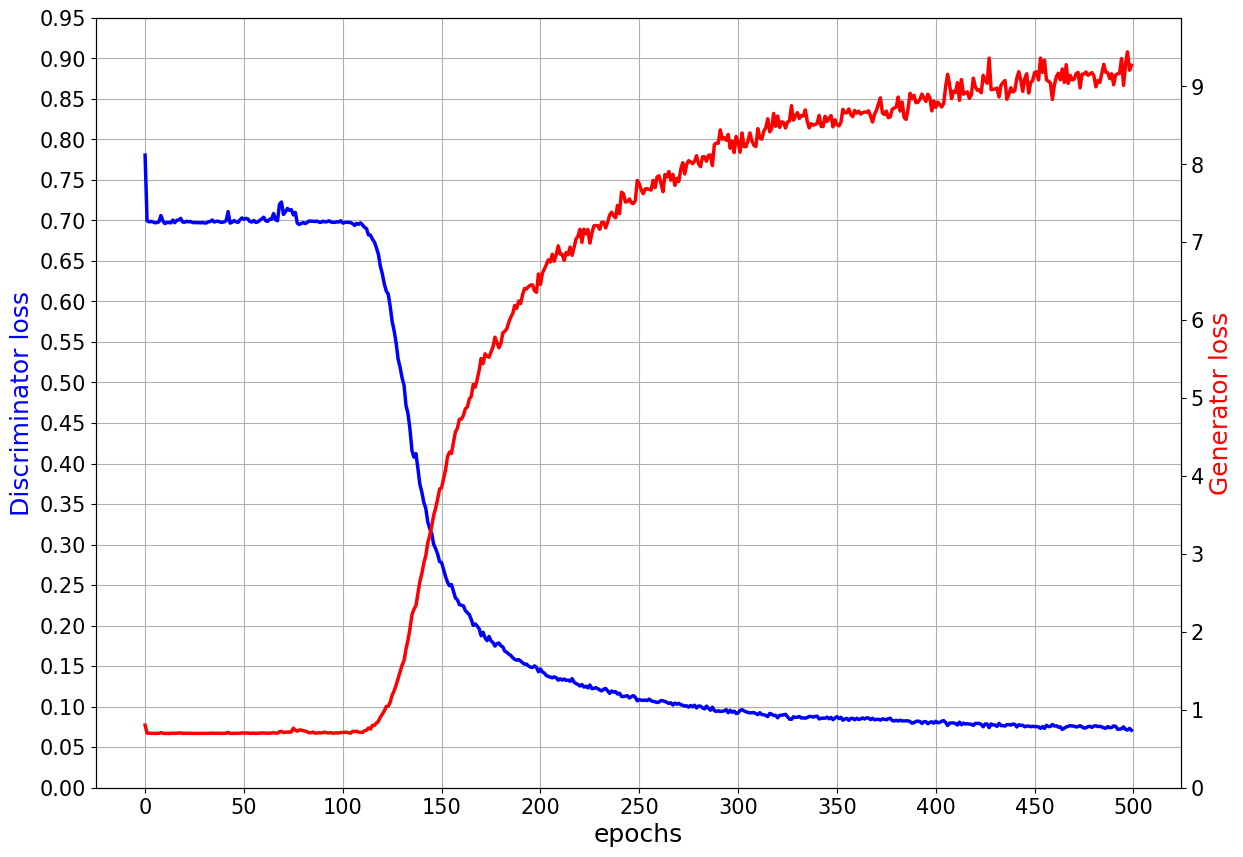

In [99]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(loss_list_D, color="blue", linewidth=2.5)
ax.set_xlabel("epochs", fontsize = 18)
# set y-axis label
ax.set_ylabel("Discriminator loss",
              color="blue",
              fontsize=18)
ax.set_xticks(np.arange(0, 550, 50))
ax.set_yticks(np.arange(0, 1, 0.05))

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

ax2 = ax.twinx()
ax2.plot(loss_list_G, color="red", linewidth=2.5)
ax2.set_ylabel("Generator loss", color="red", fontsize=18)
ax2.set_yticks(np.arange(0, 10, 1))
ax2.tick_params(axis='y', labelsize=15)
ax.grid()
plt.show()

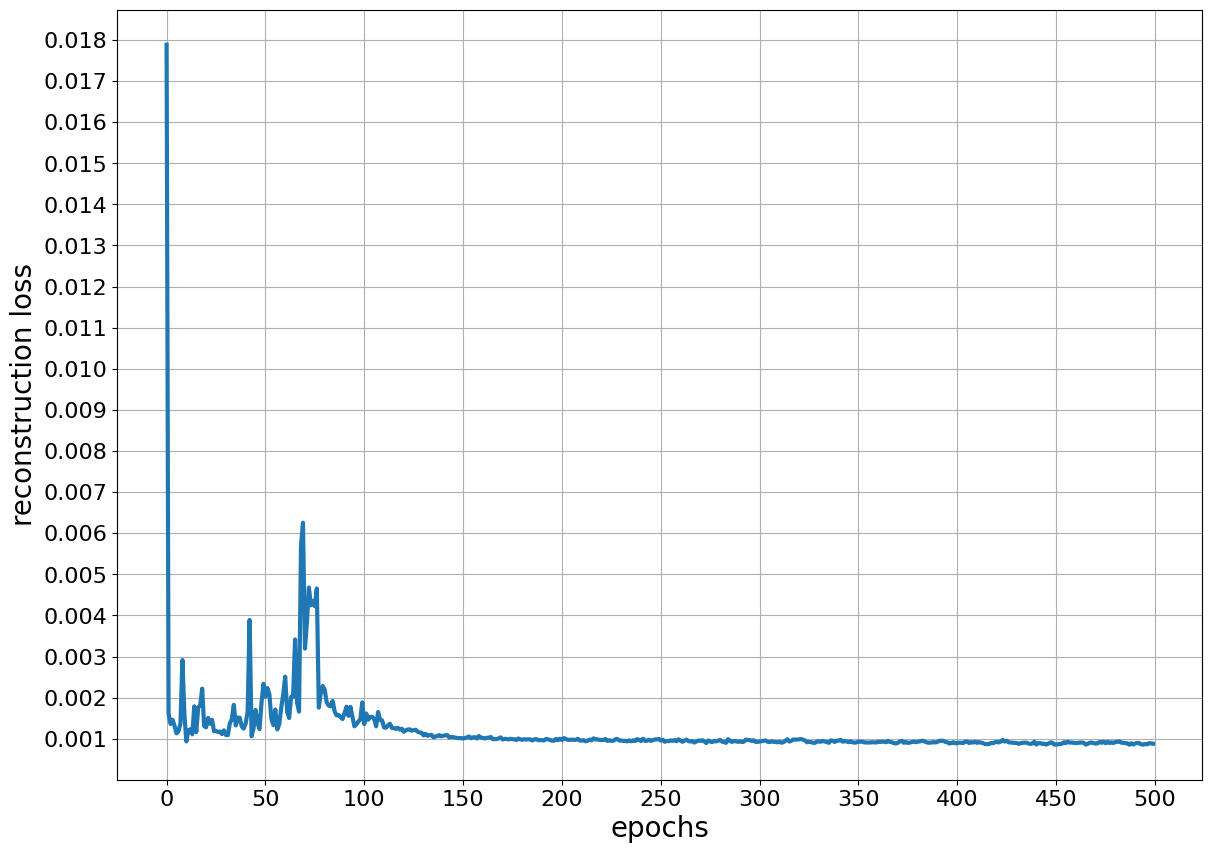

In [101]:
plt.figure(figsize=(14, 10))
plt.xlabel("epochs", fontsize=20)
plt.ylabel("reconstruction loss", fontsize=20)
plt.xticks(ticks=np.arange(0, 550, 50), fontsize=16) 
plt.yticks(ticks=np.arange(0, 0.02, 0.0010), fontsize=16)
plt.grid()
plt.plot(mse_losses, linewidth=3)

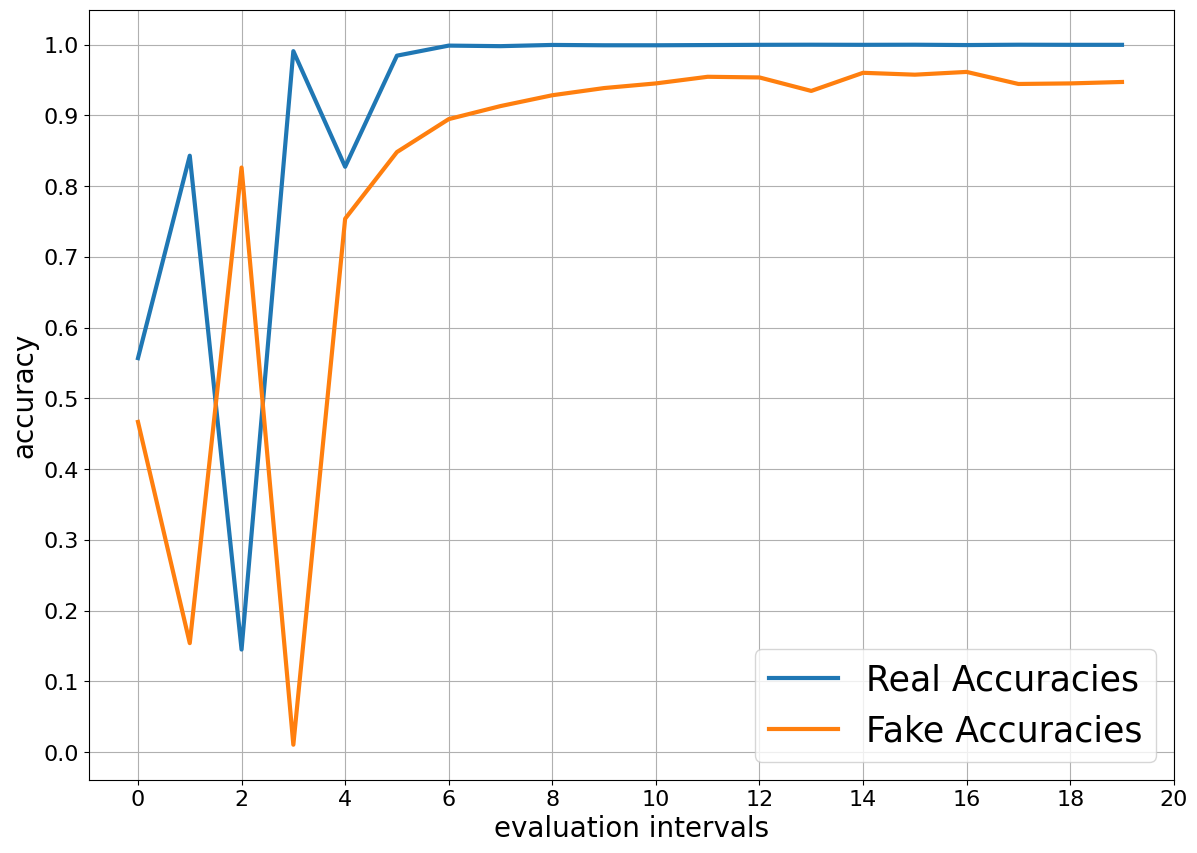

In [121]:
plt.figure(figsize=(14, 10))

plt.plot(real_accuracies, linewidth=3, label="Real Accuracies")
plt.plot(fake_accuracies, linewidth=3, label="Fake Accuracies")
plt.xlabel("evaluation intervals", fontsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.xticks(ticks=np.arange(0, 22, 2), fontsize=16)
plt.yticks(ticks=np.arange(0, 1.1, 0.1), fontsize=16)
plt.legend(loc="lower right", prop={'size': 25})
plt.grid()
plt.show();

In [122]:
generator_clone = Generator().to(device)
generator_clone.load_state_dict(torch.load("models/generator_big.pt"))

discriminator_clone = Discriminator().to(device)
discriminator_clone.load_state_dict(torch.load("models/discriminator_big.pt"))

/tmp/ipykernel_33/3592223321.py:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(module.weight)


<All keys matched successfully>

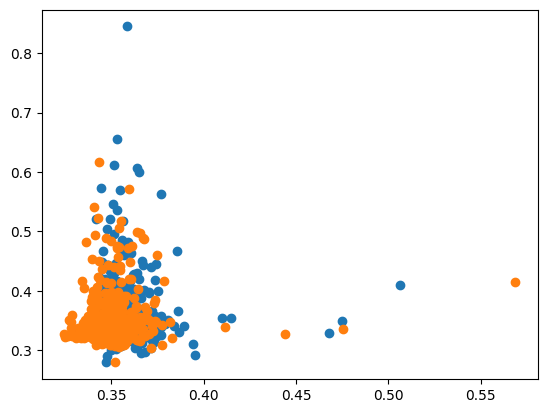

In [123]:
import numpy as np
outs = np.zeros((33, 16, 2))
actuals = np.zeros((33, 16, 2))

idx_to_compare = 12

for i, (x, y) in enumerate(dataloader):
  x, y = x.to(device), y.to(device)  
  latent_space = torch.randn(x.shape[0], latent_dim, device=device)    
  out = generator_clone(latent_space, x)
  outs[i] = out[idx_to_compare].detach().cpu().numpy()
  actuals[i] = y[idx_to_compare].detach().cpu().numpy()

  if i == 32:
    break

plt.scatter(actuals[:, :, 0].ravel(), actuals[:, :, 1].ravel())
plt.scatter(outs[:, :, 0].ravel(), outs[:, :, 1].ravel())

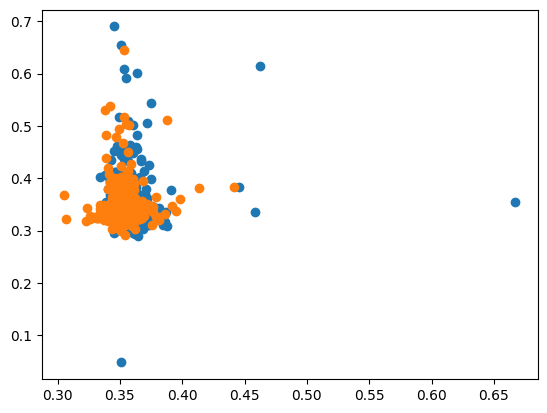

In [103]:
import numpy as np
import matplotlib.pyplot as plt 

outs = np.zeros((33, 16, 2))
actuals = np.zeros((33, 16, 2))

idx_to_compare = 12

for i, (x, y) in enumerate(dataloader):
  x, y = x.to(device), y.to(device)  
  latent_space = torch.randn(x.shape[0], latent_dim, device=device)    
  out = generator(latent_space, x)
  outs[i] = out[idx_to_compare].detach().cpu().numpy()
  actuals[i] = y[idx_to_compare].detach().cpu().numpy()

  if i == 32:
    break

plt.scatter(actuals[:, :, 0].ravel(), actuals[:, :, 1].ravel())
plt.scatter(outs[:, :, 0].ravel(), outs[:, :, 1].ravel())

In [4]:
!gdown --id "1k1PymLeDkGYNva9kD5Kn_076Hz8p0EJj&confirm=t"

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1k1PymLeDkGYNva9kD5Kn_076Hz8p0EJj&confirm=t
To: /notebooks/233209_data_norm.pt
100%|████████████████████████████████████████| 127k/127k [00:00<00:00, 15.3MB/s]
